In [183]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
import threading
import time

from datetime import datetime

## Group Assignment
### Team Number: 08
### Team Member Names: Richard Meng, Avaansh Nanda, Devesh Kotak
### Team Strategy Chosen: Market Beat

We first start by reading the CSV file of tickers and processing the tickers as a list for easy iteration.

In [184]:
# read in the csv file and set the header to none, otherwise it will treat the first ticker as the header
tickers_csv = pd.read_csv("Tickers_Example.csv", header=None)
# turn the csv dataframe into a list
tickers = list(tickers_csv[0])
tickers

['AAPL',
 'ABBV',
 'ABT',
 'ACN',
 'AGN',
 'AIG',
 'AMZN',
 'AXP',
 'BA',
 'BAC',
 'BB.TO',
 'BIIB',
 'BK',
 'BLK',
 'BMY',
 'C',
 'CAT',
 'CELG',
 'CL',
 'KO',
 'LLY',
 'LMT',
 'MO',
 'MON',
 'MRK',
 'PEP',
 'PFE',
 'PG',
 'PM',
 'PYPL',
 'QCOM',
 'RTN',
 'RY.TO',
 'SHOP.TO',
 'T.TO',
 'TD.TO',
 'TXN',
 'UNH',
 'UNP',
 'UPS',
 'USB']

Below are some helper functions to help assist filtering our stock data using data threading. 

In [185]:
#  We will be filtering 40 tickers. Each thread will handle 5 tickers which download from yfinance simultaneously, speeding up the process.
START_DATE = "2024-10-01"
END_DATE = "2025-09-30"
tickers_data = {}

# helper function to download stock data 
def download_yf(ticker_subset):
    # looping through each ticker and downloading the data from yfinance, and storing in 
    for ticker in ticker_subset:
        tickers_data[ticker] = yf.download(ticker, START_DATE, END_DATE, auto_adjust=False, progress=False)

# function to create & start a thread to download tickers' stock data from yfinance
def make_data(tickers):
    t = threading.Thread(target=download_yf, args=(tickers,))
    t.start()
    
    t.join()

# stored in a dictionary where each key pair value is the ticker, dataFrame of data
make_data(tickers)
tickers_data


1 Failed download:
['AGN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CELG']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MON']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['RTN']: YFTzMissingError('possibly delisted; no timezone found')


{'AAPL': Price        Adj Close       Close        High         Low        Open  \
 Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
 Date                                                                     
 2024-10-01  224.944046  226.210007  229.649994  223.740005  229.520004   
 2024-10-02  225.510834  226.779999  227.369995  223.020004  225.889999   
 2024-10-03  224.407043  225.669998  226.809998  223.320007  225.139999   
 2024-10-04  225.530731  226.800003  228.000000  224.130005  227.899994   
 2024-10-07  220.449326  221.690002  225.690002  221.330002  224.500000   
 ...                ...         ...         ...         ...         ...   
 2025-09-23  254.183594  254.429993  257.339996  253.580002  255.880005   
 2025-09-24  252.065643  252.309998  255.740005  251.039993  255.220001   
 2025-09-25  256.621216  256.869995  257.170013  251.710007  253.210007   
 2025-09-26  255.212601  255.460007  257.600006  253.779999  254.100006   
 2025-09-29  254.

Next, we begin filtering the stocks. We first must check that they are Canadian or American, which can be done by checking their currency. Then we check if the company is actually listed on its respective market. Lastly, we check the daily average volume (excluding months with less than 18 trading days) and exclude stocks with less than 5000 daily average volume.

In [186]:
# function to check if a singular ticker is valid, then add it to an array of results at its respective index
# this is the helper function for the thread
MIN_TRADING_DAYS = 18
MIN_VOLUME = 5000
VALID_CURRENCIES = ['USD','CAD']

def valid_ticker(ticker, results, index):
    try:
        # store the ticker as a yf.Ticker to find info on currency and sector
        yfTicker = yf.Ticker(ticker)
        # store data to get trading volume + loop through the dates to find number of trading days per month
        ticker_data = tickers_data[ticker]
        # use time.sleep so yFinance does not time out and limit our request rate due to threading
        time.sleep(2)
        # store the currency
        currency = yfTicker.fast_info.get('currency')
        # store the sector
        sector = yfTicker.info.get('sector')
        # again use time.sleep after each yFinance call so it does not limit our request rate
        time.sleep(2)
        # create a date range with the start of each month in range
        month_starts = pd.date_range(start=START_DATE, end=END_DATE, freq="MS")
        # create a date range with the end of each month in range
        month_ends = pd.date_range(start=START_DATE, end=END_DATE, freq="ME")
        # initialize current month index to 0 and num trading days equal to 0
        cur_month_idx = 0
        num_trading_days = 0
        # keep track of the tickers total volume and number of total trading days to find avg daily volume
        total_vol = 0
        total_trading_days = 0
        # initialize date index
        date_idx = 0
        dates = ticker_data.index
        # loop through each date in the ticker data
        while date_idx < len(dates) and cur_month_idx < len(month_starts):
            date = dates[date_idx]
           # if the date is less than the end date of current month it is in
            if date <= month_ends[cur_month_idx]:
                # first add one to the number of trading days
                num_trading_days += 1
                total_trading_days += 1
                # if it is greater than 18, now we check the daily average volume
                #    if its less than 5000 don't add this stock to valid stocks.
                # otherwise, if the number of trading days isn't greater than 18
                #    continue on as then we'll exclude it or wait until it goes above 18
                if num_trading_days >= MIN_TRADING_DAYS:
                    ticker_month_data = yf.download(ticker, start=month_starts[cur_month_idx], end=month_ends[cur_month_idx], auto_adjust=False, progress=False)
                    # again use time.sleep to allow our yFinance requests to go through
                    time.sleep(2)
                    # add to total volume
                    total_vol += ticker_month_data["Volume"].sum().iloc[0]
                    # find the current index of the last date, side="right" gives us the index after the last day of the month's index
                    date_idx = np.searchsorted(dates, month_ends[cur_month_idx], side="right")

            # now we have surpassed the month end and will go to the next month       
            else:
                cur_month_idx += 1
                num_trading_days = 0

            date_idx+=1
        # calculate average daily volume
        avg_daily_vol = total_vol / total_trading_days if total_trading_days > 0 else 0
        # if the average daily volume is less than the minimum or the currency is invalid, don't add the ticker (store it as None).
        if avg_daily_vol<MIN_VOLUME or not(currency in VALID_CURRENCIES):
            results[index] = None
            print(f"removed {ticker}")
        # otherwise, if it's valid, then add the key pair ticker, (sector, currency) to valid_tickers for easy access to a ticker's info.
        else:
            results[index] = (ticker, sector, currency)
    # the except will catch delisted stocks and exclude them from valid_tickers (store it as None)
    except Exception as e:
        print(f"{ticker} is delisted")
        results[index] = None

# function for threading to speed up the process
def filter_tickers(tickers):
    # initialize an list threads to store our threads and valid_tickers to get the return value of the valid_ticker function
    threads = []
    valid_tickers = [""] * len(tickers)

    # loop through the list of possible tickers and get the index and actual ticker
    for index, ticker in enumerate(tickers):
        # start a thread using the valid_ticker function and pass in its respective arguments
        t = threading.Thread(target=valid_ticker, args=(ticker, valid_tickers, index))
        # start the thread and append it to the threads list
        t.start()
        threads.append(t)

    # loop through each thread and join them
    for thread in threads:
        thread.join()
    # use a list comprehension to add to valid_tickers if the ticker is not None.
    return [v for v in valid_tickers if v]

# store the valid_tickers in a list
valid_tickers = filter_tickers(tickers)
# initalize a dictionary to store elements as ticker : (sector, currency)
ticker_dict = {}
# add all valid tickers to the dictionary
for ticker_tup in valid_tickers:
    ticker_dict[ticker_tup[0]] = ticker_tup[1::]

# then change valid_tickers to a list of only the tickers
valid_tickers = [t[0] for t in valid_tickers]

$AGN: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$RTN: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$CELG: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$MON: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")


AGN is delisted
RTN is delisted
CELG is delisted
MON is delisted


Here is the list of all tickers that follow the rules and their respective information stored in a dictionary

In [187]:
print(len(ticker_dict.keys()), len(tickers))
ticker_dict

37 41


{'AAPL': ('Technology', 'USD'),
 'ABBV': ('Healthcare', 'USD'),
 'ABT': ('Healthcare', 'USD'),
 'ACN': ('Technology', 'USD'),
 'AIG': ('Financial Services', 'USD'),
 'AMZN': ('Consumer Cyclical', 'USD'),
 'AXP': ('Financial Services', 'USD'),
 'BA': ('Industrials', 'USD'),
 'BAC': ('Financial Services', 'USD'),
 'BB.TO': ('Technology', 'CAD'),
 'BIIB': ('Healthcare', 'USD'),
 'BK': ('Financial Services', 'USD'),
 'BLK': ('Financial Services', 'USD'),
 'BMY': ('Healthcare', 'USD'),
 'C': ('Financial Services', 'USD'),
 'CAT': ('Industrials', 'USD'),
 'CL': ('Consumer Defensive', 'USD'),
 'KO': ('Consumer Defensive', 'USD'),
 'LLY': ('Healthcare', 'USD'),
 'LMT': ('Industrials', 'USD'),
 'MO': ('Consumer Defensive', 'USD'),
 'MRK': ('Healthcare', 'USD'),
 'PEP': ('Consumer Defensive', 'USD'),
 'PFE': ('Healthcare', 'USD'),
 'PG': ('Consumer Defensive', 'USD'),
 'PM': ('Consumer Defensive', 'USD'),
 'PYPL': ('Financial Services', 'USD'),
 'QCOM': ('Technology', 'USD'),
 'RY.TO': ('Financi

Since we must choose 10-25 stocks, we will first rank the top 25 stocks using a metric or scoring system we came up with.

Each stock has a score: 
* $\ 0.5*Sharpe \ Ratio + 0.5*Alpha $

We chose this metric because the Sharpe Ratio provides the risk-adjusted return, while the Alpha indicates the return above the market. 

We chose the $\ Sharpe \ Ratio$ as we still would like to be slightly risk-averse and it provides us a strong indicator of how much a stock returns given its risk. As for $\ Alpha$, this helps us with our goal, of market beat, by giving a stock's specific return above the market.

We will find the Sharpe Ratio of each stock by finding the returns of each stock, the risk-free return given by bonds (dependent on currency), and the standard deviation of each stock.

Then we will find the Alpha of each stock by finding the returns of each stock and the returns of its respective market (also dependent on currency)

Text(0, 0.5, 'Percent Change (%)')

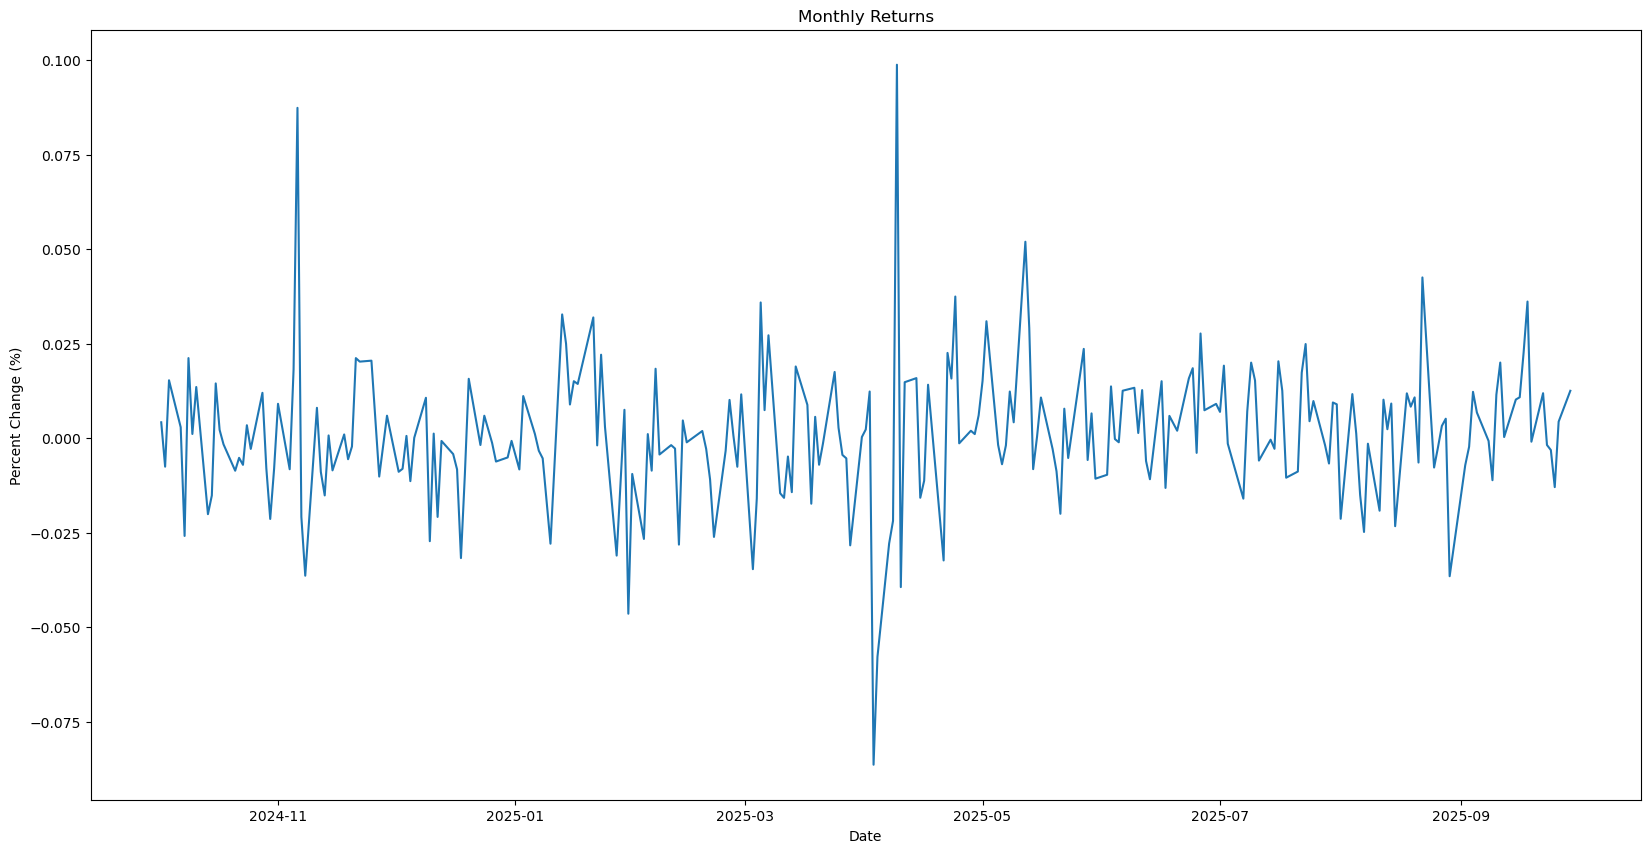

In [188]:
pct_returns = tickers_data["CAT"]['Close'].pct_change().dropna()
plt.figure(figsize=(20,10))

plt.plot(pct_returns.index, pct_returns)
plt.title('Monthly Returns')
plt.xlabel('Date')
plt.ylabel('Percent Change (%)')

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.
- Richard Meng
- Avaansh Nanda
- Devesh Kotak